In [1]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import torchmetrics
import random


os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(42)

torch.manual_seed(42) 
torch.cuda.manual_seed(42)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [2]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3,1,1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3,1,1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        
    def forward(self,x):
        return self.conv(x)

In [3]:
class Unet(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 1, features = [64,128,256,512] ):
        super().__init__()
        
        self.encoder_convs = nn.ModuleList()
        for feature in features:
            self.encoder_convs.append(DoubleConv(in_channels, feature))
            in_channels = feature
            
        self.pool = nn.MaxPool2d(2,2)
        
        self.decoder_convs = nn.ModuleList()
        self.decoder_transConvs = nn.ModuleList()
        for feature in reversed(features):
            self.decoder_convs.append(DoubleConv(feature*2, feature))
            self.decoder_transConvs.append(nn.ConvTranspose2d(feature*2, feature, 2, 2))
            
            
        self.bottleNeck = DoubleConv(features[-1], features[-1]*2)
        
        self.output_conv = nn.Conv2d(features[0], out_channels, 1)
        
        
    def forward(self, x):
        
        skip_connections = []

        #encoder
        for conv in self.encoder_convs:
            x = conv(x)
            skip_connections.append(x)
            x = self.pool(x)
    
        #bottleneck
        x = self.bottleNeck(x)
        
        skip_connections = skip_connections[::-1]
    
            
        #decoder
        for transConv, skip, conv in zip(self.decoder_transConvs, skip_connections, self.decoder_convs):
            x = transConv(x)
            x = torch.cat((skip, x), dim=1)
            x = conv(x)
            
        return self.output_conv(x)
            
                    

In [4]:
import albumentations as A
from torchvision.transforms import v2
from torchvision.datasets import OxfordIIITPet
import torch.nn.functional as F

In [5]:
class PetsWithAug(OxfordIIITPet):
    def __init__(self, root, download=True, transform=None, target_types="segmentation", split="trainval"):
        super().__init__(root, download=download, transform=None, target_types=target_types, split=split)
        self.transform = transform
        
        
    def __getitem__(self, idx):
        img, mask = super().__getitem__(idx)
        img = np.array(img)
        mask = np.array(mask)
        mask[mask==2] = 0
        mask[mask==3] = 2
        
        if self.transform is not None:
            transformed = self.transform(image=img, mask=mask)
            img = transformed["image"]
            mask = transformed['mask']
            
            
        img = v2.ToDtype(torch.float32, scale=True)(torch.from_numpy(img)).permute(2,1,0)
        mask = torch.from_numpy(mask).long()
        mask = F.one_hot(mask, num_classes=3).permute(2,1,0)
        
            
        return img, mask

In [6]:
train_transforms = A.Compose([
    A.LongestMaxSize(320),
    A.PadIfNeeded(320, 320, border_mode=0),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.ShiftScaleRotate(border_mode=0),
    A.RandomBrightnessContrast(),
    A.ElasticTransform(border_mode=0),
    A.HueSaturationValue(),
    A.RGBShift(),
    A.RandomGamma(),
    A.GaussNoise(),
    A.Blur(),
])


test_transforms = A.Compose([
    A.LongestMaxSize(320),
    A.PadIfNeeded(320, 320, border_mode=0),
])

In [7]:
root_train = "/kaggle/working/train"
root_test = "/kaggle/working/test"

train_dataset = PetsWithAug(root_train, download=False, transform=train_transforms)

test_dataset = PetsWithAug(root_test, download=False, transform=test_transforms, split="test")

# len(test) = len(train), why.......

In [8]:
from torch.utils.data import random_split
val_size = int(0.8 * len(test_dataset))
test_size = len(test_dataset) - val_size

val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size])

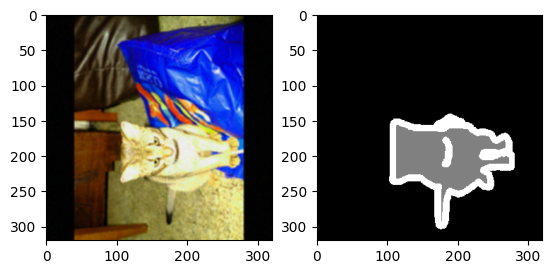

In [56]:
img, mask = train_dataset[5]
plt.subplot(1,2,1)
plt.imshow(img.permute(1,2,0))

plt.subplot(1,2,2)
plt.imshow(mask.permute(1,2,0).argmax(-1), cmap='gray')


In [10]:
LR = 3e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64
NUM_EPOCHS = 300


In [11]:
from torch.utils.data.dataloader import DataLoader


train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
val_dataloader = DataLoader(val_dataset, BATCH_SIZE, shuffle=False,num_workers=os.cpu_count(), pin_memory=True)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False,num_workers=os.cpu_count(), pin_memory=True)

In [15]:
dice = torchmetrics.Dice(ignore_index=0).to(DEVICE)

def train_fn(train_loader, model, optim, loss_fn, amp_scaler):
    
    train_total_loss = 0
    
    loop = tqdm(train_loader)
    model.train()
    
    for batch_idx, (X_train, y_train) in enumerate(loop):
        X_train, y_train = X_train.to(DEVICE), y_train.float().to(DEVICE)
        
        with torch.cuda.amp.autocast():
            train_pred = model(X_train)
            loss = loss_fn(train_pred, y_train)
            
        
        optim.zero_grad(set_to_none='True')
        amp_scaler.scale(loss).backward()
        amp_scaler.step(optim)
        amp_scaler.update()
        
        train_total_loss += loss.item()
        
        
    return train_total_loss
        
def val_fn(val_loader, model, loss_fn) :
    
    val_total_loss = 0
    val_total_dice = 0
    
    model.eval()
    with torch.inference_mode():
        loop = tqdm(val_loader)
        for batch_idx, (X_val, y_val) in enumerate(loop):
            X_val, y_val = X_val.to(DEVICE), y_val.float().to(DEVICE)
            
            val_pred = model(X_val)
            loss = loss_fn(val_pred, y_val)
            
            val_total_dice += dice(val_pred.argmax(1), y_val.argmax(1)).item()
            val_total_loss += loss.item()
            
        
    return val_total_loss, val_total_dice



def save_checkpoint(model, optim, scheduler, epoch):
    torch.save({
    "model": model.state_dict(),
    "optim": optim.state_dict(),
    "random_states": {"python_rng_state": random.getstate(), 
                      "np_rng_state": np.random.get_state(), 
                      "torch_rng_state": torch.get_rng_state(),
                      "cuda_rng_state": torch.cuda.get_rng_state(),
                      },
    "scheduler": scheduler.state_dict(),

},
    f"/kaggle/working/epoch_{epoch}.pt")
    
    
def load_checkpoint(checkpoint, model, optim, scheduler):
    model.load_state_dict(checkpoint['model'])
    optim.load_state_dict(checkpoint['optim'])

    scheduler.load_state_dict(checkpoint['scheduler'])

    random.setstate(checkpoint['random_states']['python_rng_state'])
    np.random.set_state(checkpoint['random_states']['np_rng_state'])
    torch.set_rng_state(checkpoint['random_states']['torch_rng_state'])
    torch.cuda.set_rng_state(checkpoint['random_states']['cuda_rng_state'])

In [13]:
model = Unet(in_channels=3, out_channels=3, features=[32,64,128,256]).to(DEVICE)


loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=5e-5)
amp_scaler = torch.cuda.amp.GradScaler()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=0.5, patience=5)

In [14]:
for epoch in range(NUM_EPOCHS):
    
    train_loss = train_fn(train_dataloader, model, optim, loss_fn, amp_scaler)
    
    val_loss, val_dice = val_fn(val_dataloader, model, loss_fn)
    
    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    val_dice /= len(val_dataloader)
    
    scheduler.step(val_loss)
    
    print(f"epoch_{epoch}:   train loss = {train_loss},   val loss = {val_loss}, val dice = {val_dice}")
    
    save_checkpoint(model, optim, scheduler, epoch)


100%|██████████| 46/46 [00:30<00:00,  1.53it/s]


epoch_0:   train loss = 0.7620068819358431,   val loss = 0.6484215544617694, val dice = 0.5524971005709275


100%|██████████| 46/46 [00:29<00:00,  1.59it/s]


epoch_1:   train loss = 0.5803484043170666,   val loss = 0.5672733641189077, val dice = 0.6010635132374971


100%|██████████| 46/46 [00:28<00:00,  1.60it/s]


epoch_2:   train loss = 0.5015977040447038,   val loss = 0.4895974831736606, val dice = 0.6358719442201697


100%|██████████| 46/46 [00:28<00:00,  1.60it/s]


epoch_3:   train loss = 0.4528442831902668,   val loss = 0.4234194781469262, val dice = 0.6576596887215324


100%|██████████| 46/46 [00:28<00:00,  1.59it/s]


epoch_4:   train loss = 0.4178459911510862,   val loss = 0.5480472477881805, val dice = 0.6124307189298712


100%|██████████| 46/46 [00:28<00:00,  1.59it/s]


epoch_5:   train loss = 0.3869668019228968,   val loss = 0.37021642664204474, val dice = 0.7041315980579542


100%|██████████| 46/46 [00:28<00:00,  1.60it/s]


epoch_6:   train loss = 0.3660600971558998,   val loss = 0.38290619461432746, val dice = 0.6777369626190352


100%|██████████| 46/46 [00:28<00:00,  1.60it/s]


epoch_7:   train loss = 0.352246414998482,   val loss = 0.33742546581703686, val dice = 0.7211099500241487


100%|██████████| 46/46 [00:28<00:00,  1.59it/s]


epoch_8:   train loss = 0.3352268358756756,   val loss = 0.32381878663664276, val dice = 0.7420926158842833


100%|██████████| 46/46 [00:28<00:00,  1.59it/s]


epoch_9:   train loss = 0.3298183987880575,   val loss = 0.3498158254053282, val dice = 0.7274100404718647


100%|██████████| 46/46 [00:28<00:00,  1.59it/s]


epoch_10:   train loss = 0.3176377718818599,   val loss = 0.3042404055595398, val dice = 0.754534740810809


100%|██████████| 46/46 [00:28<00:00,  1.60it/s]


epoch_11:   train loss = 0.31168641972130745,   val loss = 0.2971559983232747, val dice = 0.7535841231760771


100%|██████████| 46/46 [00:28<00:00,  1.59it/s]


epoch_12:   train loss = 0.30239171354935085,   val loss = 0.2832283588207286, val dice = 0.7652170049107593


100%|██████████| 46/46 [00:28<00:00,  1.60it/s]


epoch_13:   train loss = 0.29402627718859703,   val loss = 0.2766992132300916, val dice = 0.7722945252190465


100%|██████████| 46/46 [00:28<00:00,  1.60it/s]


epoch_14:   train loss = 0.29268605030816175,   val loss = 0.3461636414994364, val dice = 0.7399476960949276


100%|██████████| 46/46 [00:28<00:00,  1.59it/s]


epoch_15:   train loss = 0.28454624244879034,   val loss = 0.253996346955714, val dice = 0.7908019462357396


100%|██████████| 46/46 [00:28<00:00,  1.60it/s]


epoch_16:   train loss = 0.2760092556990426,   val loss = 0.2611736742698628, val dice = 0.7848189330619314


100%|██████████| 46/46 [00:28<00:00,  1.60it/s]


epoch_17:   train loss = 0.27406511378699333,   val loss = 0.31789297318976856, val dice = 0.724872975245766


100%|██████████| 46/46 [00:28<00:00,  1.61it/s]


epoch_18:   train loss = 0.27341707795858383,   val loss = 0.27780806791523227, val dice = 0.7747889627581057


100%|██████████| 46/46 [00:28<00:00,  1.60it/s]


epoch_19:   train loss = 0.25967732842626245,   val loss = 0.2555423259087231, val dice = 0.7886601349581843


100%|██████████| 46/46 [00:28<00:00,  1.59it/s]


epoch_20:   train loss = 0.25797125414527694,   val loss = 0.2620266662991565, val dice = 0.7784588259199391


100%|██████████| 46/46 [00:29<00:00,  1.57it/s]


epoch_21:   train loss = 0.25579578789143725,   val loss = 0.23120354601870413, val dice = 0.8084250766298046


100%|██████████| 46/46 [00:28<00:00,  1.61it/s]


epoch_22:   train loss = 0.25486344921177834,   val loss = 0.2626053185566612, val dice = 0.7786246849142987


100%|██████████| 46/46 [00:28<00:00,  1.61it/s]


epoch_23:   train loss = 0.24558692425489426,   val loss = 0.22580696836761807, val dice = 0.8119723317415818


100%|██████████| 46/46 [00:28<00:00,  1.61it/s]


epoch_24:   train loss = 0.24642211070348477,   val loss = 0.2318980298612429, val dice = 0.8092772714469744


100%|██████████| 46/46 [00:28<00:00,  1.61it/s]


epoch_25:   train loss = 0.24213586310888158,   val loss = 0.2349518492170002, val dice = 0.8047452232112056


100%|██████████| 46/46 [00:28<00:00,  1.61it/s]


epoch_26:   train loss = 0.23761509538724504,   val loss = 0.2661836979829747, val dice = 0.7829461862211642


 84%|████████▍ | 49/58 [02:25<00:26,  2.97s/it]


KeyboardInterrupt: 

In [ ]:
# !rm -rf /kaggle/working/epoch_5.pt

In [17]:
load_checkpoint(torch.load("/kaggle/working/epoch_23.pt"), model, optim, scheduler)

In [68]:
img, mask = test_dataset[400]

model.eval()
with torch.inference_mode():
    pred = model(img.unsqueeze(0).to(DEVICE))

(-0.5, 319.5, 319.5, -0.5)

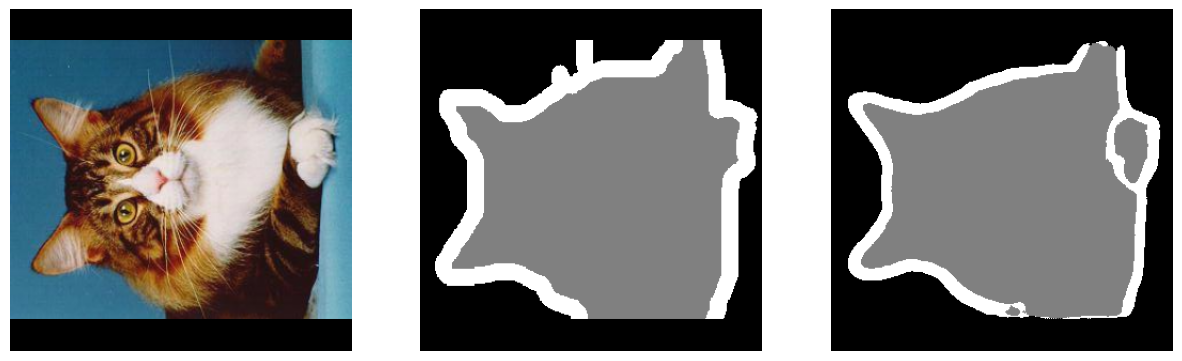

In [69]:
figure = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img.permute(1,2,0))
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(mask.permute(1,2,0).argmax(-1), cmap='gray')
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred.squeeze().cpu().permute(1,2,0).argmax(-1), cmap='gray')
plt.axis("off")